# Running model on the DataSet
 A whole-cell recording database of neuromodulatory action in the adult neocortex Xuan Yan, Niccolo Calcini, Payam Safavi, Asli Ak, Koen Kole, Fleur Zeldenrust, Tansu Celikel
bioRxiv 2022.01.12.476007; doi: https://doi.org/10.1101/2022.01.12.476007)

In [4]:
import sys 
sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *

In [5]:

path = "G:/My Drive/Analyzed/asli_1-18-7-19_E2_analyzed.mat"
data = loadmatInPy(path)

In [6]:
for i in data:
    print(i['input_generation_settings']['condition'])

ACSF
M1-ago
M1-ant


In [7]:
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

def return_partitioned_data(data,partitions,clean = True):
    input_settings = data['input_generation_settings']
    total_length = len(data['membrane_potential'])
    V = data['membrane_potential']
    I = data['input_current']
    h = data['hidden_state']
    thresholds = data['thresholds']
    if clean:
        idx = ~np.isnan(thresholds)
        thresholds = thresholds[idx]
        spks_acsf = data['spikeindices'][idx]
        threshold_idx = data['thresholdindices'][idx]
    else:
        # idx = ~np.isnan(thresholds)
        thresholds = thresholds
        spks_acsf = data['spikeindices']
        threshold_idx = data['thresholdindices']

    data_partitions = []

    for i in range(partitions):
        V_ = V[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        I_ = I[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        h_ = h[(total_length//partitions)*i:(total_length//partitions)*(i+1)]
        idx_temp = np.where((spks_acsf>=((total_length//partitions)*(i)))&(spks_acsf<((total_length//partitions)*(i+1))))
        spks_ = spks_acsf[idx_temp]-((i)*total_length//partitions)

        thresholds_ = thresholds[idx_temp]
        threshold_idx_ = threshold_idx[idx_temp]-((i)*total_length//partitions)

        data_idx = {'membrane_potential':V_,
                    'input_current':I_,
                    'hidden_state':h_,
                    'spikeindices':spks_,
                    'thresholds':thresholds_,
                    'thresholdindices':threshold_idx_,
                    'input_generation_settings':input_settings,
                    'firing_rate':len(spks_)*(input_settings['sampling_rate']*1000)/(total_length//partitions)
                    }
        data_partitions.append(data_idx)

    return data_partitions


In [14]:
part_data = return_partitioned_data(data[1],36000,clean=False)


In [15]:
time = 360*20000
h = data[1]['hidden_state'][:]
I = data[1]['input_current'][:]
spikes = data[1]['spikeindices'][:]
V = data[1]['membrane_potential'][:]


In [16]:
means = [np.mean(part_data[i]['input_current']) for i in range(len(part_data))]
means = means-np.mean(means)
vars = [np.var(part_data[i]['input_current']) for i in range(len(part_data))]
vars = vars-np.mean(vars)
frs = [part_data[i]['firing_rate'] for i in range(len(part_data))]
frs = frs-np.mean(frs)


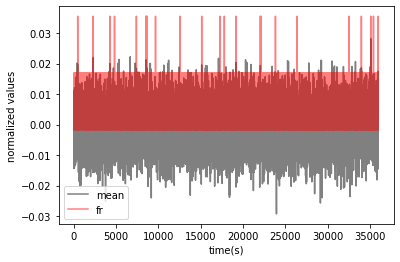

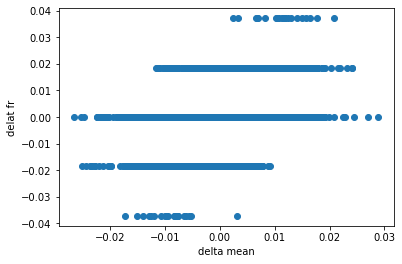

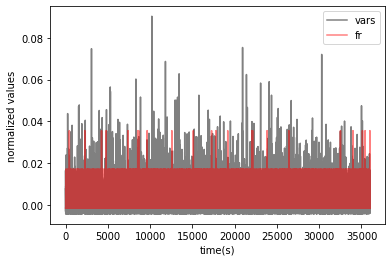

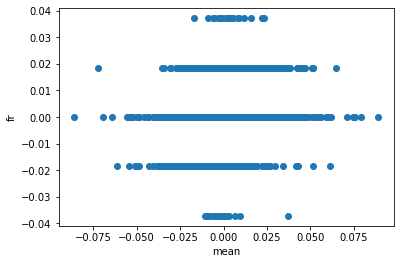

In [ ]:
# plt.plot()
means_norm = (means/np.linalg.norm(means))
means_norm -=np.mean(means_norm) 

frs_norm = (frs/np.linalg.norm(frs))
frs_norm -=np.mean(frs_norm) 

vars_norm = (vars/np.linalg.norm(vars))
vars_norm -=np.mean(vars_norm) 

plt.plot(means_norm-np.mean(means_norm),c='grey')
plt.plot(frs_norm-np.mean(frs_norm),c='red',alpha=0.5)
plt.xlabel('time(s)')
plt.ylabel('normalized values')
plt.legend(['mean','fr'])
plt.show()

plt.scatter(np.diff(means_norm),np.diff(frs_norm))
# plt.plot()
plt.xlabel('delta mean')
plt.ylabel('delat fr')
plt.show()

plt.plot(vars_norm-np.mean(vars_norm),c='grey')
plt.plot(frs_norm-np.mean(frs_norm),c='red',alpha=0.5)
plt.xlabel('time(s)')
plt.ylabel('normalized values')
plt.legend(['vars','fr'])

plt.show()


plt.scatter(np.diff(vars_norm),np.diff(frs_norm))
plt.xlabel('mean')
plt.ylabel('fr')

# plt.plot()
plt.show()


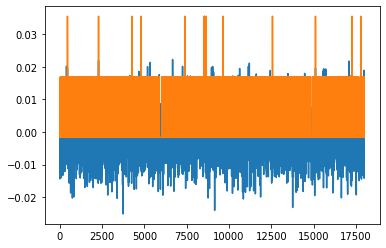

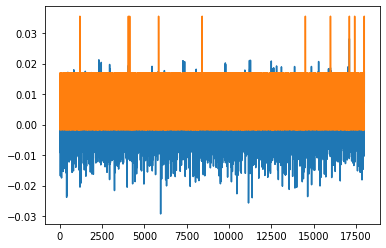

In [ ]:
plt.plot(means_norm[:len(means_norm)//2])
plt.plot(frs_norm[:len(frs_norm)//2])
plt.show()
plt.plot(means_norm[len(means_norm)//2:])
plt.plot(frs_norm[len(frs_norm)//2:])

In [ ]:
# plt.plot(np.diff(h)[:1000*20])
# plt.plot(np.diff(h))
# plt.plot(np.diff(np.array(h,dtype=np.int32)))
ups = np.where(np.diff(np.array(h,dtype=np.int32))==1)
downs = np.where(np.diff(np.array(h,dtype=np.int32))==-1)
# (downs[0]- ups[0])/20
downs[0]-ups[0]

ValueError: operands could not be broadcast together with shapes (1597,) (1598,) 

In [11]:
binary_spikes = np.zeros(len(V))

binary_spikes[spikes] =1



In [17]:
import numpy.random
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad

#Gaussian kernel (not normalized here)
def gaussian(x, sigma):
    return np.exp(-(x/sigma)**2/2) 

#convolution
def smooth(y,box_pts): 
    x = (np.linspace(-box_pts/2.,box_pts/2.,box_pts + 1)) #Gaussian centred on 0
    std_norm = 3. #3. is an arbitrary value for normalizing the sigma
    sigma = box_pts/std_norm 
    integral = quad(gaussian, x[0], x[-1], args=(sigma))[0]
    box = gaussian(x, sigma)/integral
    y_smooth = np.convolve(y,box,mode='same')
    return y_smooth


In [13]:
box_size = 100*20
spikes_smooth = smooth(binary_spikes,box_size)

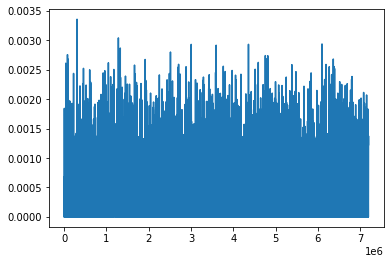

In [12]:
plt.plot(spikes_smooth)

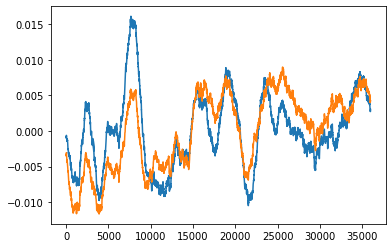

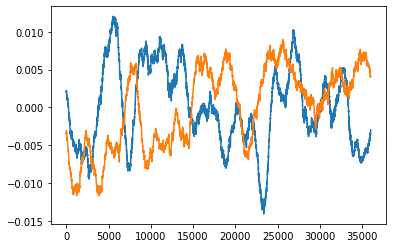

In [18]:

box_size = 100*20

fr_smooth = smooth(frs,box_size)
mean_smooth = smooth(means,box_size)
var_smooth = smooth(vars,box_size)


plt.plot(mean_smooth/np.linalg.norm(mean_smooth))# plt.show()
plt.plot(fr_smooth/np.linalg.norm(fr_smooth))
plt.show()

plt.plot(var_smooth/np.linalg.norm(var_smooth))# plt.show()
plt.plot(fr_smooth/np.linalg.norm(fr_smooth))
plt.show()


